# Import necessary libraries

In [6]:
%store -r final_data
%store -r encoding_mappings

import torch
import os
import wget
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt 

from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from pathlib import Path

np.random.seed(0)
sb.set() 
model = TabNetRegressor(device_name='cuda') 


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [7]:
def encode_new_input(new_input, encoding_mappings):
# If new_input is a dictionary, convert it to a DataFrame
    if isinstance(new_input, dict):
        new_input = pd.DataFrame([new_input])
    
    # If new_input is a list of dictionaries, convert it to a DataFrame
    elif isinstance(new_input, list):
        new_input = pd.DataFrame(new_input)

    # Ensure that new_input is a DataFrame at this point
    if not isinstance(new_input, pd.DataFrame):
        raise ValueError("new_input must be a pandas DataFrame, a dictionary, or a list of dictionaries.")    
    new_input_encoded = new_input.copy()
    for column, mapping in encoding_mappings.items():
        if column in new_input.columns:
            # Apply the mapping to the column
            new_input_encoded[column] = new_input[column].map(mapping)
            # Fill in NaN values if the category was not seen during training
            if new_input_encoded[column].isna().any():
                unknown_rank = np.median(list(mapping.values()))
                # Use direct assignment instead of inplace=True
                new_input_encoded[column] = new_input_encoded[column].fillna(unknown_rank)
    
    return new_input_encoded

# Employing basic linearing regression model with the numerical data

In [8]:
final_data.head()

,Year,Month,lease_commence_date,floor_area_sqm,average_storey,resale_price_adjusted,town,flat_type,flat_model
0,2000,1,1986,69.0,8.0,219202.861724,1,2,6
1,2000,1,1970,66.0,5.0,216220.509864,6,2,6
2,2000,1,1970,72.0,17.0,310164.593460,6,2,6
3,2000,1,1970,72.0,5.0,277358.722998,6,2,6
4,2000,1,1970,72.0,2.0,271394.019278,6,2,6


In [9]:
skewness_values = final_data[['floor_area_sqm', 'lease_commence_date','resale_price_adjusted','average_storey','town','flat_type','flat_model']].skew()

# Print the skewness value for each column
print(skewness_values)

columns = ['floor_area_sqm', 'lease_commence_date','resale_price_adjusted']

for col in columns:
    plt.figure(figsize=(8, 4))
    sb.histplot(final_data[col], kde=False)
    plt.title(f'Histogram of {col} (Skewness: {skewness_values[col]:.2f})')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()


floor_area_sqm           0.295712
lease_commence_date      0.374158
resale_price_adjusted    1.003236
average_storey           1.425422
town                     0.178356
flat_type                0.319618
flat_model               1.121342
dtype: float64


NameError: name 'sns' is not defined

<Figure size 800x400 with 0 Axes>

Goodness of Fit of Model on Train Dataset:
Explained Variance (R^2): 0.5974426759046065
Mean Squared Error (MSE): 12258995583.321077

Goodness of Fit of Model on Test Dataset:
Explained Variance (R^2): 0.5968202628607608
Mean Squared Error (MSE): 12374896505.21619



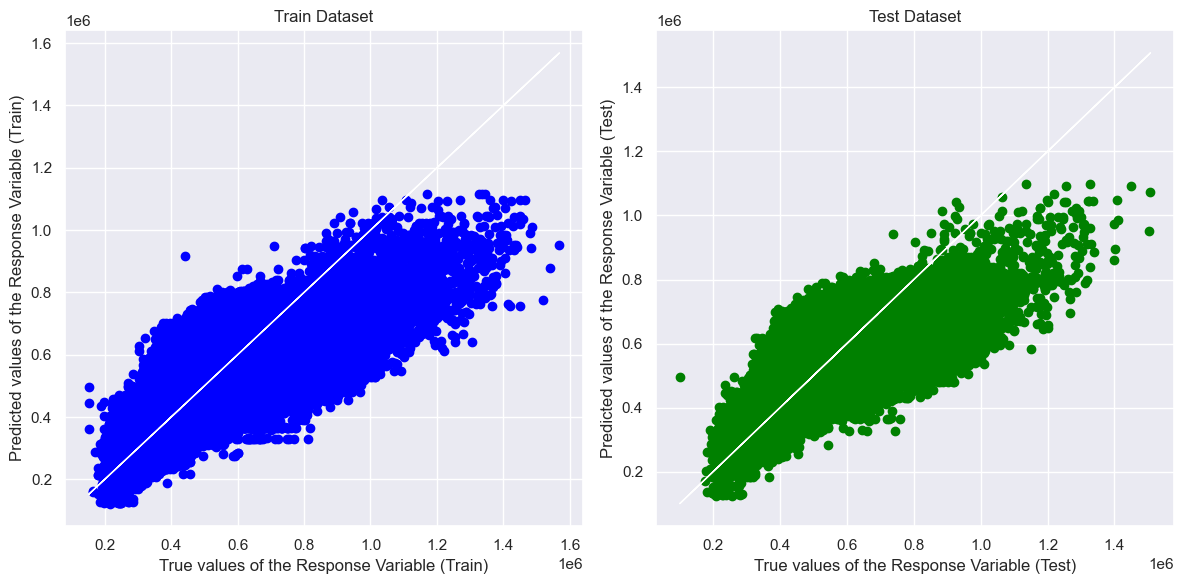

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


X = pd.concat([final_data[['floor_area_sqm', 'lease_commence_date', 'average_storey','town', 'flat_type', 'flat_model']]])
y = final_data['resale_price_adjusted']
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Predictions
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# Model Evaluation
print("Goodness of Fit of Model on Train Dataset:")
print("Explained Variance (R^2):", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE):", mean_squared_error(y_train, y_train_pred))
print()

print("Goodness of Fit of Model on Test Dataset:")
print("Explained Variance (R^2):", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_test_pred))
print()

# Plot the Predictions versus True values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, color="blue")
plt.plot(y_train, y_train, 'w-', linewidth=1)
plt.xlabel("True values of the Response Variable (Train)")
plt.ylabel("Predicted values of the Response Variable (Train)")
plt.title("Train Dataset")

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, color="green")
plt.plot(y_test, y_test, 'w-', linewidth=1)
plt.xlabel("True values of the Response Variable (Test)")
plt.ylabel("Predicted values of the Response Variable (Test)")
plt.title("Test Dataset")

plt.tight_layout()
plt.show()

Goodness of Fit of Model on Train Dataset:
Explained Variance (R^2): 0.6511043670723011
Mean Squared Error (MSE): 289664099803.46716

Goodness of Fit of Model on Test Dataset:
Explained Variance (R^2): 0.6499844698384668
Mean Squared Error (MSE): 291342243561.7433



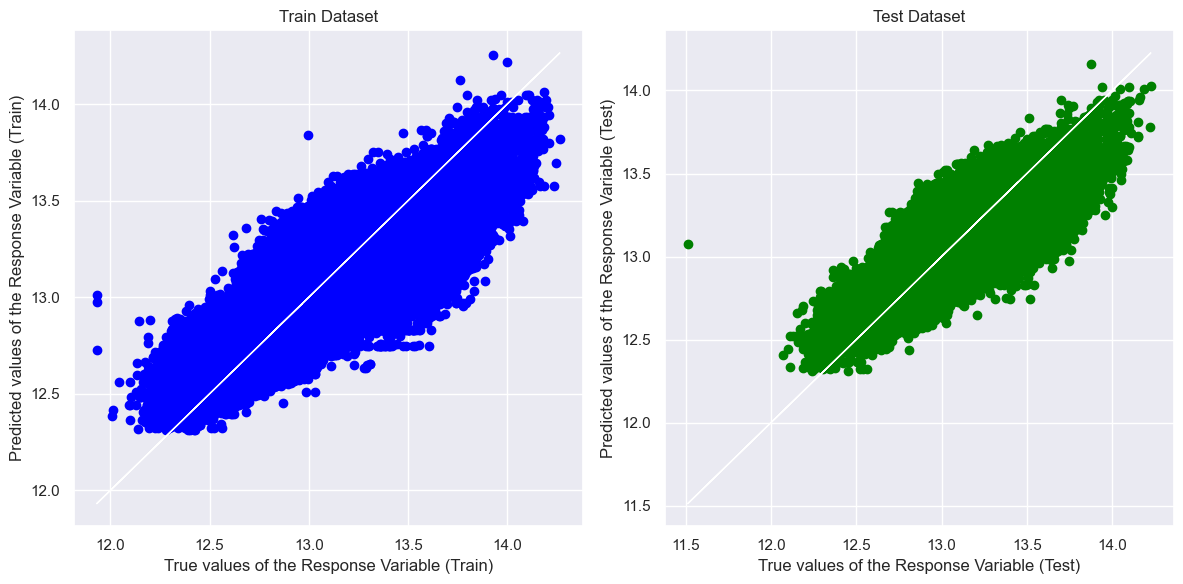

In [ ]:
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

# Train a linear regression model
linreg_withLog = LinearRegression()
linreg_withLog.fit(X_train, y_train_log)

y_train_pred_log = linreg_withLog.predict(X_train)
y_test_pred_log = linreg_withLog.predict(X_test)

print("Goodness of Fit of Model on Train Dataset:")
print("Explained Variance (R^2):", linreg_withLog.score(X_train, y_train_log))
print("Mean Squared Error (MSE):", mean_squared_error(y_train, y_train_pred_log))
print()

print("Goodness of Fit of Model on Test Dataset:")
print("Explained Variance (R^2):", linreg_withLog.score(X_test, y_test_log))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_test_pred_log))
print()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train_log, y_train_pred_log, color="blue")
plt.plot(y_train_log, y_train_log, 'w-', linewidth=1)
plt.xlabel("True values of the Response Variable (Train)")
plt.ylabel("Predicted values of the Response Variable (Train)")
plt.title("Train Dataset")

plt.subplot(1, 2, 2)
plt.scatter(y_test_log, y_test_pred_log, color="green")
plt.plot(y_test_log, y_test_log, 'w-', linewidth=1)
plt.xlabel("True values of the Response Variable (Test)")
plt.ylabel("Predicted values of the Response Variable (Test)")
plt.title("Test Dataset")

plt.tight_layout()
plt.show()

In [ ]:
new_sample = {
    'floor_area_sqm': 100,
    'lease_commence_date': 2020,
    'average_storey': 10,
    'town': 'ANG MO KIO',
    'flat_type': '5 ROOM',
    'flat_model': 'Simplified'
}

new_sample_df = pd.DataFrame([new_sample])

encoded_user_input_linreg = encode_new_input(new_sample_df, encoding_mappings)

predicted_resale_value_linreg = linreg.predict(encoded_user_input_linreg)

print(f"Predicted Resale Value: {predicted_resale_value_linreg[0]}")

Predicted Resale Value: 521586.48239852395


# Load data and split

In [ ]:
# Assuming 'encoded_data' is a preprocessed DataFrame where categorical columns are already encoded.
train = final_data
target = 'resale_price_adjusted'

# Randomly assign rows to train, valid, and test sets if not already done.
if 'Set' not in train.columns:
    train['Set'] = np.random.choice(["train", "valid", "test"], p=[.8, .1, .1], size=(train.shape[0],))

# Get indices for each set.
train_indices = train[train.Set == "train"].index
valid_indices = train[train.Set == "valid"].index
test_indices = train[train.Set == "test"].index

train.head(20)


,floor_area_sqm,lease_commence_date,resale_price_adjusted,average_storey,town,flat_type,flat_model,Set
0,60.0,1986,249701.035010,8.0,0,2,6,train
1,86.0,2001,335872.372582,2.0,9,3,4,train
2,90.0,2000,332934.713346,8.0,9,3,5,train
3,90.0,2004,331955.493601,5.0,9,3,5,train
4,117.0,2012,930258.757879,20.0,23,4,6,train
5,124.0,2012,807856.289737,5.0,23,4,6,train
6,110.0,2006,805702.006298,5.0,23,4,6,train
7,111.0,2003,763791.401206,29.0,23,4,6,valid
8,115.0,2000,734414.808852,2.0,23,4,6,test
9,90.0,2008,750082.324774,32.0,23,3,5,train


In [ ]:
# Define features to exclude from the model and the categorical columns
unused_feat = ['Set']
categorical_columns = ['town', 'flat_type', 'flat_model'] 

# Create a list of features to be used for training
features = ['floor_area_sqm','lease_commence_date','average_storey','town','flat_type','flat_model'] 

# Identify the index positions of categorical features in the 'features' list
cat_idxs = [i for i, f in enumerate(features) if f in categorical_columns]

# Compute the cardinality (number of unique values) for each categorical feature
categorical_dims = {col: train[col].nunique() for col in categorical_columns}
cat_dims = [categorical_dims[f] for f in features if f in categorical_columns]


# # Define the embedding sizes for categorical features
# cat_emb_dim = [min(50, (dim + 1) // 2) for dim in cat_dims]

print(cat_idxs)
print(cat_dims)
# print(cat_emb_dim)

[3, 4, 5]
[26, 7, 21]


In [ ]:
# Initialize the TabNetRegressor with the defined categorical dimensions and embedding sizes
clf = TabNetRegressor(cat_dims=cat_dims, cat_emb_dim=cat_dims, cat_idxs=cat_idxs)


/Users/kur0/Documents/Year1/sc1015_lab/SC1015_Mini_Proj/.mini/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


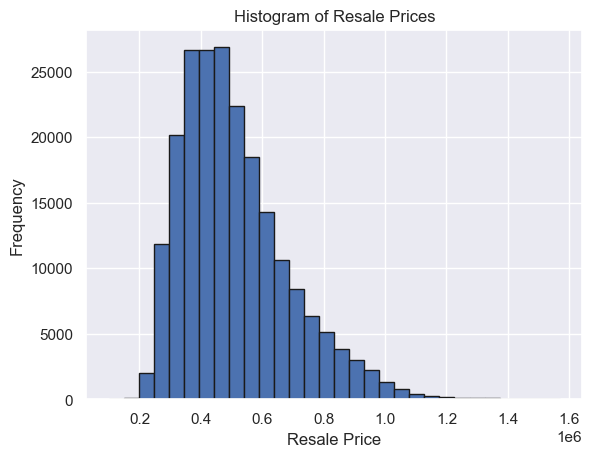

In [ ]:
resale_price_adjusted = train['resale_price_adjusted']

plt.hist(resale_price_adjusted, bins=30, edgecolor='k')
plt.title('Histogram of Resale Prices')
plt.xlabel('Resale Price')
plt.ylabel('Frequency')
# hello
plt.show()

### very skewed 

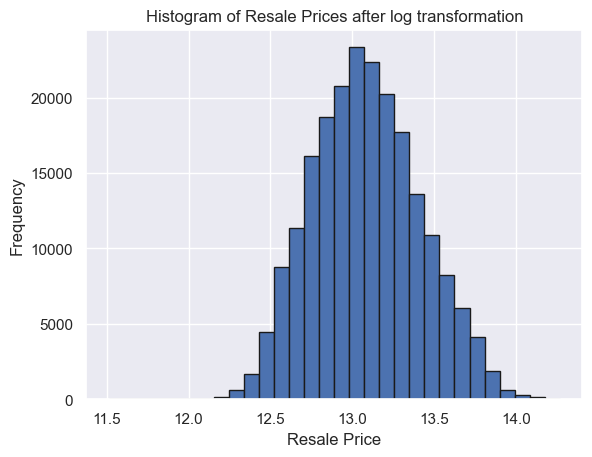

In [ ]:
np.set_printoptions(suppress=True)

train['log_' + target] = np.log(train[target])

log_resale_price_adjusted = train['log_resale_price_adjusted']

plt.hist(log_resale_price_adjusted, bins=30, edgecolor='k')
plt.title('Histogram of Resale Prices after log transformation')
plt.xlabel('Resale Price')
plt.ylabel('Frequency')

plt.show()

In [ ]:
X_train = train.loc[train_indices, features].values
y_train = train.loc[train_indices, target].values.reshape(-1, 1)
y_train_log = train.loc[train_indices, 'log_' + target].values.reshape(-1, 1)

X_valid = train.loc[valid_indices, features].values
y_valid = train.loc[valid_indices, target].values.reshape(-1, 1)
y_valid_log = train.loc[valid_indices, 'log_' + target].values.reshape(-1, 1)

X_test = train.loc[test_indices, features].values
y_test = train.loc[test_indices, target].values.reshape(-1, 1)
y_test_log = train.loc[test_indices, 'log_' + target].values.reshape(-1, 1)



In [ ]:
print(y_test_log.size)
print(y_test.size)
print(X_test.shape)

X_test

21313
21313
(21313, 6)


array([[ 115., 2000.,    2.,   23.,    4.,    6.],
       [ 106., 1997.,    8.,   23.,    3.,    5.],
       [ 130., 2000.,   11.,    9.,    5.,    8.],
       ...,
       [  67., 1984.,    8.,   12.,    2.,    2.],
       [  84., 1985.,   11.,   12.,    3.,    3.],
       [ 105., 1990.,    2.,   12.,    3.,    5.]])

In [ ]:
# Fit the TabNetRegressor on the training data
max_epochs = 200
clf.fit(
    X_train, y_train_log,
    eval_set=[(X_train, y_train_log), (X_valid, y_valid_log)],
    eval_name=['train', 'valid'],
    eval_metric=['rmse'],
    max_epochs=max_epochs,
    patience=20,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)


epoch 0  | loss: 12.19458| train_rmse: 34.38452| valid_rmse: 34.41288|  0:00:07s
epoch 1  | loss: 0.03768 | train_rmse: 1.9307  | valid_rmse: 1.94754 |  0:00:16s
epoch 2  | loss: 0.02476 | train_rmse: 0.40199 | valid_rmse: 0.41354 |  0:00:24s
epoch 3  | loss: 0.02267 | train_rmse: 0.15402 | valid_rmse: 0.15374 |  0:00:32s
epoch 4  | loss: 0.02134 | train_rmse: 0.13718 | valid_rmse: 0.13653 |  0:00:39s
epoch 5  | loss: 0.02009 | train_rmse: 0.13626 | valid_rmse: 0.13538 |  0:00:47s
epoch 6  | loss: 0.02064 | train_rmse: 0.1285  | valid_rmse: 0.12743 |  0:00:55s
epoch 7  | loss: 0.01971 | train_rmse: 0.14061 | valid_rmse: 0.13996 |  0:01:03s
epoch 8  | loss: 0.01905 | train_rmse: 0.14756 | valid_rmse: 0.14627 |  0:01:11s
epoch 9  | loss: 0.02001 | train_rmse: 0.13823 | valid_rmse: 0.13765 |  0:01:19s
epoch 10 | loss: 0.02263 | train_rmse: 0.1236  | valid_rmse: 0.12272 |  0:01:27s
epoch 11 | loss: 0.01831 | train_rmse: 0.12164 | valid_rmse: 0.12035 |  0:01:35s
epoch 12 | loss: 0.01765 | t

/Users/kur0/Documents/Year1/sc1015_lab/SC1015_Mini_Proj/.mini/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


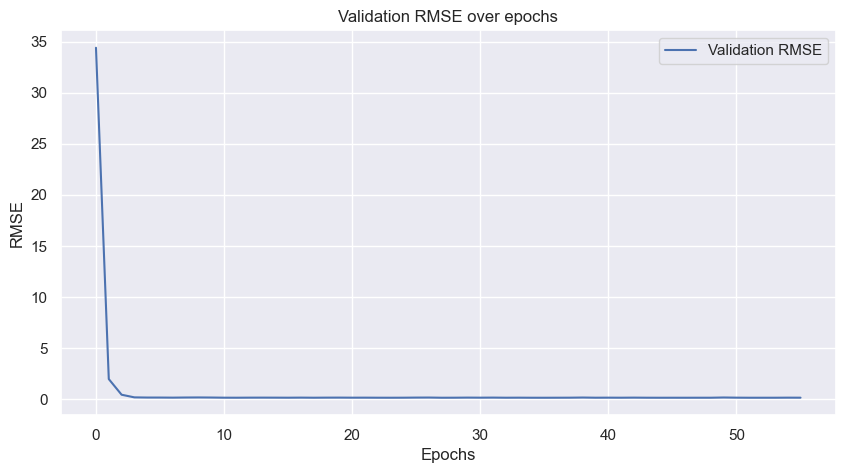

In [ ]:
valid_rmse = clf.history['valid_rmse']

epochs = range(len(valid_rmse))

plt.figure(figsize=(10,5))
plt.plot(epochs, valid_rmse, label='Validation RMSE')
plt.title('Validation RMSE over epochs')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

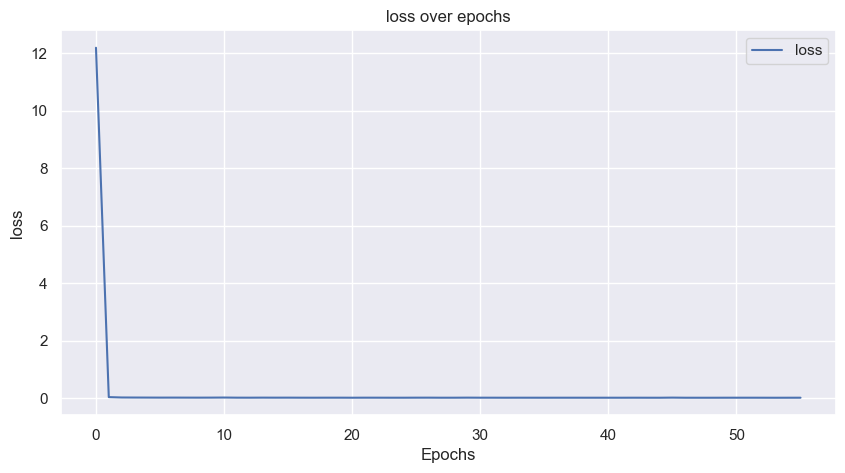

In [ ]:
loss = clf.history['loss']

epochs = range(len(loss))

plt.figure(figsize=(10,5))
plt.plot(epochs, loss, label='loss')
plt.title('loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
# Predict and evaluate the model on the test set
predictions = clf.predict(X_test)

# Calculate RMSE for the test set predictions
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test_log, predictions))
print(f"RMSE on test set: {rmse}")

RMSE on test set: 0.11757177131236636


In [ ]:
from sklearn.metrics import r2_score

y_test_pred = np.exp(predictions)  
r2_withLog = r2_score(y_test_log, predictions)
r2 = r2_score(y_test, y_test_pred)  

print(f"R^2 on test set before transformation: {r2_withLog}")
print(f"R^2 on test set after transformation: {r2}")


R^2 on test set before transformation: 0.8721728668455879
R^2 on test set after transformation: 0.8743222250521505


In [ ]:
print(encoding_mappings)

train

{'town': {'ANG MO KIO': 0, 'YISHUN': 1, 'BEDOK': 2, 'BUKIT BATOK': 3, 'GEYLANG': 4, 'WOODLANDS': 5, 'TOA PAYOH': 6, 'JURONG EAST': 7, 'JURONG WEST': 8, 'SEMBAWANG': 9, 'CHOA CHU KANG': 10, 'CLEMENTI': 11, 'HOUGANG': 12, 'BUKIT PANJANG': 13, 'SENGKANG': 14, 'MARINE PARADE': 15, 'TAMPINES': 16, 'SERANGOON': 17, 'PUNGGOL': 18, 'KALLANG/WHAMPOA': 19, 'PASIR RIS': 20, 'CENTRAL AREA': 21, 'BUKIT MERAH': 22, 'QUEENSTOWN': 23, 'BISHAN': 24, 'BUKIT TIMAH': 25}, 'flat_type': {'1 ROOM': 0, '2 ROOM': 1, '3 ROOM': 2, '4 ROOM': 3, '5 ROOM': 4, 'EXECUTIVE': 5, 'MULTI-GENERATION': 6}, 'flat_model': {'2-room': 0, 'Standard': 1, 'New Generation': 2, 'Simplified': 3, 'Model A2': 4, 'Model A': 5, 'Improved': 6, 'Premium Apartment': 7, 'Apartment': 8, '3Gen': 9, 'Improved-Maisonette': 10, 'Maisonette': 11, 'Adjoined flat': 12, 'Model A-Maisonette': 13, 'DBSS': 14, 'Premium Maisonette': 15, 'Multi Generation': 16, 'Terrace': 17, 'Type S1': 18, 'Premium Apartment Loft': 19, 'Type S2': 20}}


,floor_area_sqm,lease_commence_date,resale_price_adjusted,average_storey,town,flat_type,flat_model,Set,log_resale_price_adjusted
0,60.0,1986,249701.035010,8.0,0,2,6,train,12.428020
1,86.0,2001,335872.372582,2.0,9,3,4,train,12.724487
2,90.0,2000,332934.713346,8.0,9,3,5,train,12.715702
3,90.0,2004,331955.493601,5.0,9,3,5,train,12.712756
4,117.0,2012,930258.757879,20.0,23,4,6,train,13.743218
...,...,...,...,...,...,...,...,...,...
212143,105.0,1990,538888.000000,2.0,12,3,5,test,13.197263
212144,91.0,1985,538000.000000,11.0,12,3,2,valid,13.195614
212145,98.0,1978,538000.000000,8.0,12,3,2,train,13.195614
212146,92.0,2019,573000.000000,5.0,12,3,5,train,13.258641


In [ ]:
new_sample = {
    'floor_area_sqm': 143,
    'lease_commence_date': 2021,
    'average_storey': 10,
    'town': 'JURONG WEST',
    'flat_type': '5 ROOM',
    'flat_model': 'Apartment'
}

new_sample_df = pd.DataFrame([new_sample])

encoded_user_input1 = encode_new_input(new_sample, encoding_mappings)
encoded_user_input2 = encode_new_input(new_sample_df, encoding_mappings)
encoded_user_input_array = encoded_user_input1.to_numpy()

#annoying coz clf.predict take in array but linreg.predict take in df
predicted_resale_price_clf = np.exp(clf.predict(encoded_user_input_array))
predicted_resale_price_linreg = linreg.predict(encoded_user_input2)
predicted_resale_price_linreg_withLog = np.exp(linreg_withLog.predict(encoded_user_input2))

print(f"Predicted Resale Value for clf:                         {predicted_resale_price_clf[0]}")
print(f"Predicted Resale Value for linreg:                      {predicted_resale_price_linreg[0]}")
print(f"Predicted Resale Value for linreg with transformation:  {predicted_resale_price_linreg_withLog[0]}")

Predicted Resale Value for clf:                         [781666.44]
Predicted Resale Value for linreg:                      731076.8776443554
Predicted Resale Value for linreg with transformation:  773891.7261294534
